### Fine Tuning Task  

강아지, 머핀 이진 분류  
https://drive.google.com/file/d/1Q_KC2nTmGlX2PeINWwV63_kpTjnoVpiO/view?usp=sharing

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/muffin/original/'

image_data_generator = ImageDataGenerator(rescale =1./255)

generator = image_data_generator.flow_from_directory(
    root,
    target_size = (64, 64),
    batch_size=64,
    class_mode='binary'
)

print(generator.class_indices)

Found 4733 images belonging to 2 classes.
{'chihuahua': 0, 'muffin': 1}


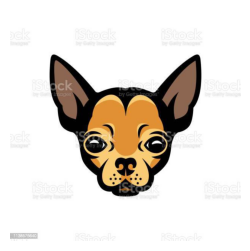

In [2]:
import cv2
import matplotlib.pyplot as plt

image = cv2.cvtColor(cv2.imread(generator.filepaths[0]), cv2.COLOR_BGR2RGB)

def show_image(image):
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.axis('off')

show_image(image)

In [3]:
import pandas as pd

s_df = pd.DataFrame({'file_paths': generator.filepaths, 'targets': generator.classes})
# s_df.loc[:, 'file_paths'] = x_df.file_paths.apply(lambda x: x.replace('\\', '/'))
# s_df.file_paths.iloc[:1]

original_max_colwidth = pd.get_option('display.max_colwidth')

# 생략 없이 전체 경로가 출력되도록 설정
pd.set_option('display.max_colwidth', None)

# DataFrame 출력
print(s_df.file_paths.iloc[:1])

# 원래 설정 값으로 복원
pd.set_option('display.max_colwidth', original_max_colwidth)

s_df


0    ./datasets/muffin/original/chihuahua/img_0_0.jpg
Name: file_paths, dtype: object


,file_paths,targets
0,./datasets/muffin/original/chihuahua/img_0_0.jpg,0
1,./datasets/muffin/original/chihuahua/img_0_1.jpg,0
2,./datasets/muffin/original/chihuahua/img_0_10.jpg,0
3,./datasets/muffin/original/chihuahua/img_0_100...,0
4,./datasets/muffin/original/chihuahua/img_0_100...,0
...,...,...
4728,./datasets/muffin/original/muffin/img_4_984.jpg,1
4729,./datasets/muffin/original/muffin/img_4_990.jpg,1
4730,./datasets/muffin/original/muffin/img_4_995.jpg,1
4731,./datasets/muffin/original/muffin/img_4_998.jpg,1


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = \
train_test_split(s_df.file_paths, s_df.targets, stratify=s_df.targets, test_size=0.2, random_state=124)

print(X_train.count())
print(X_val.count())

3786
947


In [5]:
import shutil
import os

root = './datasets/muffin/'

for file_path in X_train:
    dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'train/' + dir)
    # print(destination)
    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)

In [6]:
import shutil
import os

root = './datasets/muffin/'

for file_path in X_val:
    dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'validation/' + dir)
    
    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)

In [7]:
import albumentations as A

def transform(image):
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
    ], p=0.2)
    return aug(image=image)['image']

idg = ImageDataGenerator(preprocessing_function=transform, rescale=1./255)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 144

train_dir = './datasets/muffin/train/'
validation_dir = './datasets/muffin/validation/'
test_dir = './datasets/muffin/test/'

train_data_generator = idg
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

# 과적합 발생 시 batch size를 낮추고 과소적합 발생시 batch size를 높인다. 단, 비율에 따라서 조절할 것.
train_generator = train_data_generator.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_data_generator.flow_from_directory(
    validation_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='binary'
)

print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

Found 3786 images belonging to 2 classes.
Found 947 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.
{'chihuahua': 0, 'muffin': 1}
{'chihuahua': 0, 'muffin': 1}
{'chihuahua': 0, 'muffin': 1}


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16

IMAGE_SIZE = 144
BATCH_SIZE = 64

model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# 분류기
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(10, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=model.input, outputs=output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 144, 144, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 144, 144, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 144, 144, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 72, 72, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 72, 72, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 36, 36, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 36, 36, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 36, 36, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,829 (56.15 MB)

 Trainable params: 14,719,829 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import gc

gc.collect()

1834

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy, BinaryCrossentropy

model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['acc'])

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

In [13]:
N_EPOCHS = 3

history = model.fit(train_generator,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_generator,
                    callbacks=[mcp_cb, rlr_cb, ely_cb]
                   )

Epoch 1/3


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 ━━━━━━━━━━━━━━━━━━━━ 1181s 10s/step - acc: 0.5397 - loss: 1.3505 - val_acc: 0.5407 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 2/3
119/119 ━━━━━━━━━━━━━━━━━━━━ 1104s 9s/step - acc: 0.5509 - loss: 0.6916 - val_acc: 0.5407 - val_loss: 0.6912 - learning_rate: 0.0010
Epoch 3/3
119/119 ━━━━━━━━━━━━━━━━━━━━ 963s 8s/step - acc: 0.5329 - loss: 0.6915 - val_acc: 0.5407 - val_loss: 0.6905 - learning_rate: 0.0010


In [14]:
model.evaluate(test_generator, batch_size=64)

37/37 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - acc: 0.5701 - loss: 0.6880


[0.6905507445335388, 0.5405405163764954]

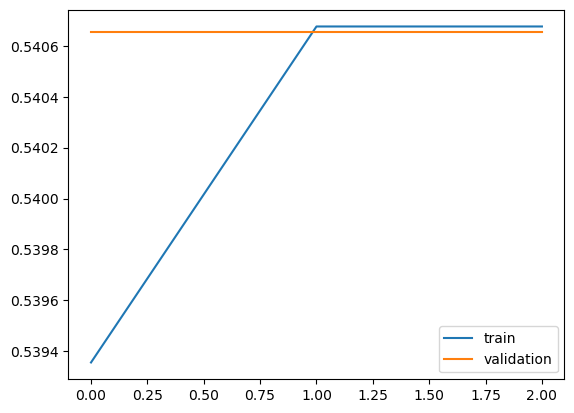

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()

In [16]:
# import numpy as np
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions

# # model = VGG16()
# image = load_img('./datasets/muffin/test/muffin/img_0_1000.jpg', target_size=(144, 144))
# image = img_to_array(image)
 
# image = np.expand_dims(image, axis=0)
# prediction = model.predict(image)
# target = decode_predictions(prediction)
# print(target)
# print(target[0][0])
# print(target[0][0][1], f'{np.round(target[0][0][2] * 100, 4)}%')

In [17]:
# import numpy as np
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# import matplotlib.pyplot as plt

# def load_and_preprocess_image(image_path, target_size):
#     image = load_img(image_path, target_size=target_size)
#     image = img_to_array(image)
#     image = np.expand_dims(image, axis=0)
#     image = image / 255.0  # 정규화
#     return image

# def show_image(image_path, title=""):
#     image = load_img(image_path)
#     plt.figure(figsize=(4, 4))
#     plt.imshow(image)
#     plt.axis('off')
#     plt.title(title)
#     plt.show()

# # 모델 로드 (이미 훈련된 모델을 로드하거나, 앞서 정의된 모델 사용)
# # model = load_model('path_to_saved_model')  # 저장된 모델이 있다면 로드

# # 또는 이미 정의된 모델을 사용
# # model = create_model(model_name='mobilenet', verbose=True)
# # model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

# # 예측할 이미지 경로
# test_image_path = './datasets/muffin/test/muffin/img_0_1000.jpg' # 실제 테스트 이미지 경로로 변경
# # 이미지 로드 및 전처리
# test_image = load_and_preprocess_image(test_image_path, target_size=(64, 64))

# # 예측 수행
# prediction = model.predict(test_image)

# # 예측 결과 해석
# predicted_value = prediction[0][0]
# label = "Bird" if predicted_value >= 0.5 else "Drone"
# # label = "Drone" if predicted_value >= 0.5 else "Bird"
# confidence = predicted_value if predicted_value >= 0.5 else 1 - predicted_value

# # 결과 표시
# show_image(test_image_path, title=f"Prediction: {label} ({confidence * 100:.2f}%)")

# fine tuning

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_root = './datasets/muffin/train/'
validation_root = './datasets/muffin/validation/'
test_root = './datasets/muffin/test/'

train_idg = ImageDataGenerator(rescale=1./255)
validation_idg = ImageDataGenerator(rescale=1./255)
test_idg = ImageDataGenerator(rescale=1./255)

train_generator = train_idg.flow_from_directory(train_root, target_size=(144, 144), batch_size=32, class_mode='binary', shuffle=True)
print(train_generator.class_indices)

validation_generator = validation_idg.flow_from_directory(validation_root, target_size=(144, 144), batch_size=32, class_mode='binary')
print(validation_generator.class_indices)

test_generator = test_idg.flow_from_directory(test_root, target_size=(144, 144), batch_size=32, class_mode='binary')
print(test_generator.class_indices)

Found 3786 images belonging to 2 classes.
{'chihuahua': 0, 'muffin': 1}
Found 947 images belonging to 2 classes.
{'chihuahua': 0, 'muffin': 1}
Found 1184 images belonging to 2 classes.
{'chihuahua': 0, 'muffin': 1}


In [19]:
train_target_name = {v: k for k, v in train_generator.class_indices.items()}
print(train_target_name)

validation_target_name = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_target_name)

test_target_name = {v: k for k, v in test_generator.class_indices.items()}
print(test_target_name)

{0: 'chihuahua', 1: 'muffin'}
{0: 'chihuahua', 1: 'muffin'}
{0: 'chihuahua', 1: 'muffin'}


In [20]:
train_target_names = []
for target in train_generator.classes:
    train_target_names.append(train_target_name[target])

validation_target_names = []
for target in validation_generator.classes:
    validation_target_names.append(validation_target_name[target])

test_target_names = []
for target in test_generator.classes:
    test_target_names.append(test_target_name[target])
    

In [21]:
import pandas as pd

# 배열의 길이를 확인합니다
filepaths_len = len(validation_generator.filepaths)
target_names_len = len(validation_target_names)
classes_len = len(validation_generator.classes)

print(f"Filepaths length: {filepaths_len}")
print(f"Target names length: {target_names_len}")
print(f"Classes length: {classes_len}")

# # 길이가 동일하지 않으면 조정합니다
# min_len = min(filepaths_len, target_names_len, classes_len)

# train_df = pd.DataFrame({
#     'file_paths': train_generator.filepaths[:min_len],
#     'target_names': train_target_names[:min_len],
#     'targets': train_generator.classes[:min_len]
# })

# display(train_df)


Filepaths length: 947
Target names length: 947
Classes length: 947


In [22]:
import pandas as pd

train_df = pd.DataFrame({'file_paths': train_generator.filepaths,'target_names': train_target_names, 'targets': train_generator.classes})
display(train_df)

validation_df = pd.DataFrame({'file_paths': validation_generator.filepaths,'target_names': validation_target_names, 'targets': validation_generator.classes})
display(validation_df)

test_df = pd.DataFrame({'file_paths': test_generator.filepaths,'target_names': test_target_names, 'targets': test_generator.classes})
display(test_df)

,file_paths,target_names,targets
0,./datasets/muffin/train/chihuahua/img_0_0.jpg,chihuahua,0
1,./datasets/muffin/train/chihuahua/img_0_1.jpg,chihuahua,0
2,./datasets/muffin/train/chihuahua/img_0_10.jpg,chihuahua,0
3,./datasets/muffin/train/chihuahua/img_0_100.jpg,chihuahua,0
4,./datasets/muffin/train/chihuahua/img_0_1003.jpg,chihuahua,0
...,...,...,...
3781,./datasets/muffin/train/muffin/img_4_984.jpg,muffin,1
3782,./datasets/muffin/train/muffin/img_4_990.jpg,muffin,1
3783,./datasets/muffin/train/muffin/img_4_995.jpg,muffin,1
3784,./datasets/muffin/train/muffin/img_4_998.jpg,muffin,1


,file_paths,target_names,targets
0,./datasets/muffin/validation/chihuahua/img_0_1...,chihuahua,0
1,./datasets/muffin/validation/chihuahua/img_0_1...,chihuahua,0
2,./datasets/muffin/validation/chihuahua/img_0_1...,chihuahua,0
3,./datasets/muffin/validation/chihuahua/img_0_1...,chihuahua,0
4,./datasets/muffin/validation/chihuahua/img_0_1...,chihuahua,0
...,...,...,...
942,./datasets/muffin/validation/muffin/img_4_947.jpg,muffin,1
943,./datasets/muffin/validation/muffin/img_4_952.jpg,muffin,1
944,./datasets/muffin/validation/muffin/img_4_959.jpg,muffin,1
945,./datasets/muffin/validation/muffin/img_4_968.jpg,muffin,1


,file_paths,target_names,targets
0,./datasets/muffin/test/chihuahua/img_0_1071.jpg,chihuahua,0
1,./datasets/muffin/test/chihuahua/img_0_1074.jpg,chihuahua,0
2,./datasets/muffin/test/chihuahua/img_0_1082.jpg,chihuahua,0
3,./datasets/muffin/test/chihuahua/img_0_1087.jpg,chihuahua,0
4,./datasets/muffin/test/chihuahua/img_0_11.jpg,chihuahua,0
...,...,...,...
1179,./datasets/muffin/test/muffin/img_4_979.jpg,muffin,1
1180,./datasets/muffin/test/muffin/img_4_989.jpg,muffin,1
1181,./datasets/muffin/test/muffin/img_4_991.jpg,muffin,1
1182,./datasets/muffin/test/muffin/img_4_996.jpg,muffin,1


In [23]:
print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(3786, 3)
(947, 3)
(1184, 3)


In [24]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

IMAGE_SIZE = 144
BATCH_SIZE = 64

class Dataset(Sequence):
    def __init__(self, file_paths, targets, batch_size=BATCH_SIZE, aug=None, preprocess=None, shuffle=False):
        self.file_paths = file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.aug = aug
        self.preprocess = preprocess
        self.shuffle = shuffle

        if self.shuffle:
            # 에포크 종료 시, 객체 생성 및 데이터 섞기
            # 메모리 이슈가 있기 때문에 재정의 필요 (아래쪽 메소드 확인!)
            self.on_epoch_end()

    # __len__()는 전체 데이터 건수에서 batch_size 단위로 나눈 데이터 수
    # 예를 들어, 1000개의 데이터를 30 batch_size로 설정하면, 1 batch 당 33.33.. 개이다.
    # 이 때, 소수점은 무조건 올려서 33 + 1 = 34 개로 설정한다.
    def __len__(self):
        return int(np.ceil(len(self.targets) / self.batch_size))


    # batch_size 단위로 이미지 배열과 타켓 데이터들을 가져온 뒤 변환한 값을 리턴한다.
    # index : 몇번째 배치인지 나타내는 변수 (len에서 정의한 개수의 배치 수)
    # index: 0 
    # 0: batch)size
    # index * self.batch_size: (index+1) * self.batch_size
    def __getitem__(self, index):
        file_paths_batch = self.file_paths[index * self.batch_size: (index + 1) * self.batch_size]
        targets_batch = self.targets[index * self.batch_size: (index + 1) * self.batch_size]

        results_batch = np.zeros((file_paths_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

        # 이미지의 경우 증강을 하거나 불러올 때 1개씩 처리되기 때문에 반복을 통해 이미지 변환을 시켜준다
        for i in range(file_paths_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(file_paths_batch[i]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

            if self.aug is not None:
                image = self.aug(image=image)['image']

            # 분포를 맞추기 위해 해당 부분 추가
            if self.preprocess is not None:
                image = self.preprocess(image)

            results_batch[i] = image

        return results_batch, targets_batch


    # 메모리 이슈가 있기 때문에 직접 재정의
    # (file, target) 이 한쌍이 묶여서 섞여야함
    def on_epoch_end(self):
        if self.shuffle:
            self.file_paths, self.targets = shuffle(self.file_paths, self.targets)
        

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D, BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2


def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobileneet': # 제한적인 장치에서 효과적인 모델
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [26]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy, BinaryCrossentropy

model = create_model(model_name='vgg16', verbose=True)
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['acc'])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 144, 144, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 144, 144, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 144, 144, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 72, 72, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 72, 72, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 36, 36, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 36, 36, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 36, 36, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,389 (56.23 MB)

 Trainable params: 14,740,389 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.layers

[<InputLayer name=input_layer_1, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <MaxPooling2D name=block1_pool, built=True>,
 <Conv2D name=block2_conv1, built=True>,
 <Conv2D name=block2_conv2, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <Conv2D name=block3_conv1, built=True>,
 <Conv2D name=block3_conv2, built=True>,
 <Conv2D name=block3_conv3, built=True>,
 <MaxPooling2D name=block3_pool, built=True>,
 <Conv2D name=block4_conv1, built=True>,
 <Conv2D name=block4_conv2, built=True>,
 <Conv2D name=block4_conv3, built=True>,
 <MaxPooling2D name=block4_pool, built=True>,
 <Conv2D name=block5_conv1, built=True>,
 <Conv2D name=block5_conv2, built=True>,
 <Conv2D name=block5_conv3, built=True>,
 <MaxPooling2D name=block5_pool, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d_1, built=True>,
 <Dense name=dense_2, built=True>,
 <Dense name=output, built=True>]

In [28]:
# freeze 확인하기
for i, layer in enumerate(model.layers[:-3]):
    layer.trainable = False
    print(i + 1, '.', layer.name, 'trainable:', layer.trainable)

print('\n######### classifier layers ######### ')
for layer in model.layers[-3:]:
    print(layer.name, 'trainable:', layer.trainable)

1 . input_layer_1 trainable: False
2 . block1_conv1 trainable: False
3 . block1_conv2 trainable: False
4 . block1_pool trainable: False
5 . block2_conv1 trainable: False
6 . block2_conv2 trainable: False
7 . block2_pool trainable: False
8 . block3_conv1 trainable: False
9 . block3_conv2 trainable: False
10 . block3_conv3 trainable: False
11 . block3_pool trainable: False
12 . block4_conv1 trainable: False
13 . block4_conv2 trainable: False
14 . block4_conv3 trainable: False
15 . block4_pool trainable: False
16 . block5_conv1 trainable: False
17 . block5_conv2 trainable: False
18 . block5_conv3 trainable: False
19 . block5_pool trainable: False

######### classifier layers ######### 
global_average_pooling2d_1 trainable: True
dense_2 trainable: True
output trainable: True


In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from tensorflow.keras import layers

IMAGE_SIZE = 144
BATCH_SIZE = 64

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 3
    SECOND_EPOCHS = 3
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=vgg_preprocess_input, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=vgg_preprocess_input)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['acc'])

    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # 부분 freeze 진행 (필요할 때 1,3 사분면 진행 시 실제로 개수를 새서 위부터 freeze 를 작성해줘야 한다.)
    # 이 부분에 작성이 필요함
    # 필요시 사이에 추가해서 작성할 것.

    model.compile(optimizer=Adam(0.00001), loss=BinaryCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset)

    return model, history

In [30]:
import gc

gc.collect()

2856

In [31]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values # 이진 레이블

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values # 이진 레이블

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values # 이진 레이블

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg_preprocess_input)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 144, 144, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 144, 144, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 144, 144, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 72, 72, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 72, 72, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 36, 36, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 36, 36, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 36, 36, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,389 (56.23 MB)

 Trainable params: 14,740,389 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 339s 6s/step - acc: 0.8257 - loss: 1.7606 - val_acc: 0.9715 - val_loss: 0.2078
Epoch 2/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 385s 6s/step - acc: 0.9759 - loss: 0.0965 - val_acc: 0.9757 - val_loss: 0.1258
Epoch 3/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 383s 6s/step - acc: 0.9824 - loss: 0.0543 - val_acc: 0.9810 - val_loss: 0.1057
Epoch 1/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 1118s 19s/step - acc: 0.9838 - loss: 0.0569 - val_acc: 0.9831 - val_loss: 0.0861
Epoch 2/3
45/60 ━━━━━━━━━━━━━━━━━━━━ 4:08 17s/step - acc: 0.9905 - loss: 0.0302


KeyboardInterrupt



In [32]:
test_dataset = Dataset(test_file_paths, 
                            test_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=vgg_preprocess_input)

model.evaluate(test_dataset, batch_size=64)

19/19 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - acc: 0.7942 - loss: 5.4907


[15.286474227905273, 0.5143581032752991]

In [ ]:
# import numpy as np
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions

# # image = load_img('./datasets/mui', target_size=(144, 114))
# image = img_to_array(image)
 
# image = np.expand_dims(image, axis=0)
# prediction = model.predict(image)
# target = decode_predictions(prediction)
# print(target)
# print(target[0][0])
# print(target[0][0][1], f'{np.round(target[0][0][2] * 100, 4)}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


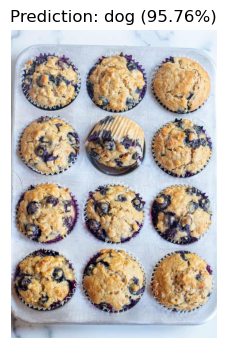

In [84]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0  # 정규화
    # 업로드된 이미지에 대하여 preprocess 적용
    image = vgg_preprocess_input(image)
    return image

def show_image(image_path, title=""):
    image = load_img(image_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.show()

# 예측할 이미지 경로
test_image_path = './datasets/muffin/test/muffin/img_0_629.jpg'  # 실제 테스트 이미지 경로로 변경

# 이미지 로드 및 전처리
test_image = load_and_preprocess_image(test_image_path, target_size=(144, 144)) 

# 예측 수행
prediction = model.predict(test_image)

# 예측 결과 해석
predicted_value = prediction[0][0]
label = "muffin" if predicted_value >= 0.5 else "dog"
confidence = predicted_value if predicted_value >= 0.5 else 1 - predicted_value

# 결과 표시
show_image(test_image_path, title=f"Prediction: {label} ({confidence * 100:.2f}%)")

In [85]:
prediction

array([[0.04243503]], dtype=float32)

In [60]:
# import numpy as np
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions

# # model = VGG16()
# image = load_img('./datasets/muffin/test/chihuahua/img_0_1082.jpg', target_size=(144, 144))
# image = img_to_array(image)
 
# image = np.expand_dims(image, axis=0)

# prediction = model.predict(image)
# # target = decode_predictions(prediction)
# # print(target)
# # print(target[0][0])
# # print(target[0][0][1], f'{np.round(target[0][0][2] * 100, 4)}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [61]:
prediction_

array([[1.551308e-11]], dtype=float32)